# Decision Tree from the Scratch

A modifield version of:
Decision Tree from the Scratch, Rakend Dubba (Computational Engineer | Data Scientist).
*Source:* https://medium.com/@rakendd/decision-tree-from-scratch-9e23bcfb4928.

In [106]:
import numpy as np
import pandas as pd
eps = np.finfo(float).eps
from numpy import log2 as log
from anytree import Node, RenderTree
from anytree import search as anys
from anytree.exporter import DotExporter
from IPython.display import Image

In [3]:
dataset = {'Taste':['Salty','Spicy','Spicy','Spicy','Spicy','Sweet','Salty','Sweet','Spicy','Salty'],
       'Temperature':['Hot','Hot','Hot','Cold','Hot','Cold','Cold','Hot','Cold','Hot'],
       'Texture':['Soft','Soft','Hard','Hard','Hard','Soft','Soft','Soft','Soft','Hard'],
       'Eat':['No','No','Yes','No','Yes','Yes','No','Yes','Yes','Yes']}
df = pd.DataFrame(dataset,columns=['Taste','Temperature','Texture','Eat'])
Target = 'Eat'

##### Dataset

There is a dataset with attributes (features) $X$, labels $Y$, classes $\Omega$ (Target) and $N$ samples :

In [4]:
df

,Taste,Temperature,Texture,Eat
0,Salty,Hot,Soft,No
1,Spicy,Hot,Soft,No
2,Spicy,Hot,Hard,Yes
3,Spicy,Cold,Hard,No
4,Spicy,Hot,Hard,Yes
5,Sweet,Cold,Soft,Yes
6,Salty,Cold,Soft,No
7,Sweet,Hot,Soft,Yes
8,Spicy,Cold,Soft,Yes
9,Salty,Hot,Hard,Yes


##### Impurity functions:

- **Gini index** [Gini, 1912]:

$ i_G(t) = \sum\limits_{k \forall \Omega} p_{kt}(1 - p_{kt}) $

- **Shannon entropy** [Shannon and Waver, 1949]:

$ i_H(t) = \sum\limits_{k \forall \Omega} |p_{kt}\log_2(p_{kt})| $

With the set of classes $\Omega$ and the probability of $k$-classe given node $t$: $p_{kt} \triangleq p(c_k|t) ~|~ p(c_k|t) \in [0, 1]$.
Obs.: some authors uses $S$ (common symbol) to denote *entropy*, here we use $i$ (impurity).
Obs. 2: see Figure 3.1 and 3.3 in Louppe [2014] for a better view of a decision tree structure.

- **Fcuntion defined**:

$ i_T(t) = \sum\limits_{k \forall \Omega} f_T(p_{kt}) $

$f_T(x) =  \begin{cases} 
      x(1-x) & T = \text{Gini} \\
      |x\log_2(x)| & T = \text{Shannon} \\
   \end{cases} $

Were $T$ is the type of impurity (Gini or Shannon).

In [5]:
def impurity_ft(pkt, gini = True):
    if (gini):
        return pkt*(1 - pkt)
    else:
        return -pkt*log(pkt)
    
def impurity(pkt_vec, gini = True):
    s = 0
    for k in range(0,len(pkt_vec)):
        s += impurity_ft(pkt[k], gini)
    return s

##### Gain information functions:

The main idea is create a node decision (*split* the input data) to increase the (discrminant) information (i.e., reduces the entropy). We present two ways for measure this:

Considering two functions of gain information, with $ p_T = \frac{N_{t_T}}{N_t} $, $s = \{s : i ~|~ \text{split using} ~X_i\}$ and $N_t$ samples passing in the node $t$:

- Kwok and Carter [1990] (?):

$ \delta(s,t) = i(t) - p_s i(t_s)$

- Louppe [2014] (?) (not used in this work):

$ \delta(s,t) = i(t) - p_{Ss} g(t_{Ss}) \left |_{S = L, R} \right . $

$ g(t) = 1 - \max\limits_{c \in \Omega} p(c|t) $

With a gain of information funcion $\delta(\cdot)$ (i.e., decrese impurity function), $t$ node before the split $s$, $t_S$ child node side $S$ ($S$ is for right $R$ or left $L$), $i(t)$ for all samples remaing in node $t$, $t_s$ for samples remaing in node $t$ from $X_i$.



In [6]:
def delta_inf(pkt_vec_t, pkt_vec_Xi, p_Xi, gini = True):
    return impurity(pkt_vec_t, gini) - p_Xi*impurity(pkt_vec_Xi, gini)

##### Algorithm to biuld the tree.

**$l$-th level:**

1) For each $i$ node in $l$-th level:
    
$s_{i,l} = \arg\max\limits_{s}\delta(s,t_{i,l-1})$

2) Create each value for $X_j,~ j = \{j : s_{i,l}\}$: $t_{i,l+1}$.

3) For $t_{i,l+1}$ with one class only, let out.


In [2]:
def find_entropy(df):
    entropy = 0
    values = df[Target].unique()
    for value in values:
        temp = df[Target].value_counts()[value]/len(df[Target])
        entropy += -temp*np.log2(temp)
    return entropy

def find_entropy_attribute(df,attribute):
    target_variables = df[Target].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[Target] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        entropy2 += -(den/len(df))*entropy
    return abs(entropy2)


def find_winner(df):
    IG = []
    for key in df.columns.difference([Target]):
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return df.columns.difference([Target])[np.argmax(IG)]

def buildtree(df,tree=None, mytree=None):
    node = find_winner(df)
    attValue = np.unique(df[node])

    if tree is None:
        tree={}
        tree[node] = {}

    for value in attValue:

        subtable = df[df[node] == value].reset_index(drop=True)
        clValue,counts = np.unique(subtable[Target],return_counts=True)

        if (len(clValue)==1):
            tree[node][value] = clValue[0]
            print(node +' : '+value+' : '+clValue[0])
        else:
            tree[node][value] = buildtree(subtable)
            print(node +' : '+value+' : *')
    return tree

def predict(inst,tree):

    for nodes in tree.keys():        
        
        value = inst[nodes]
        tree = tree[nodes][value]
        prediction = 0
            
        if type(tree) is dict:
            prediction = predict(inst, tree)
        else:
            prediction = tree
            break;                            
        
    return prediction

# Only to see

def print_tree(arg):
    for pre, fill, node in RenderTree(arg):
        print("%s%s" % (pre, node.name))
        
def converte_para_anytree(tree,node=None,mytree=None):
    
    if node is None:
        temp = list(tree.keys())
        node = temp[0]
        mytree = {}
        mytree[node] = Node(node)
        converte_para_anytree(tree,node,mytree)
    else:
        tree = tree[node]
        childs = list(tree.keys())
        for child in childs:
            if ((tree[child] == 'Yes') or (tree[child] == 'No')):
                temp = mytree[node]
                mytree[child] = Node(child, parent=temp, target=tree[child])
            else:
                temp = mytree[node]
                mytree[child] = Node(child, parent=temp)
                converte_para_anytree(tree,child,mytree)
                
    return mytree

#anys.findall_by_attr(mytree['Taste'], name="target", value='Yes')

def mostra_tree(tree):
    mytree = converte_para_anytree(tree)

    temp = list(tree.keys())
    root = temp[0]
    mytree[root]

    for pre, fill, node in RenderTree(mytree[root]):
        txt_node = str(node)
        if  "\'Yes\'" in txt_node:
            print("%s%s" % (pre, node.name+': Yes'))
        elif "\'No\'" in txt_node:
            print("%s%s" % (pre, node.name+': No'))
        else:
            print("%s%s" % (pre, node.name))
            
    DotExporter(mytree[root]).to_picture("tree.png")
    Image(filename='tree.png') 

In [3]:
tree = None
tree = buildtree(df)

NameError: name 'df' is not defined

In [1]:
mostra_tree(tree)

NameError: name 'mostra_tree' is not defined

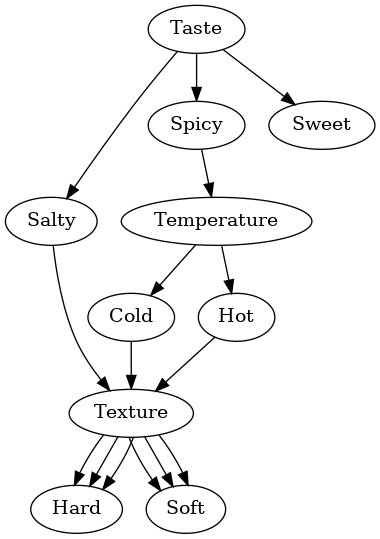

##### Tow predictions

In [121]:
test = df.sample(1).iloc[0]

In [122]:
test

Taste          Salty
Temperature      Hot
Texture         Hard
Eat              Yes
Name: 9, dtype: object

In [123]:
predict(test,tree)

'Yes'

In [131]:
test.Taste = 'Salty'
test.Temperature = 'Cold'
test.Texture = 'Hard'
test.Eat = 'unknown'

In [132]:
test

Taste            Salty
Temperature       Cold
Texture           Hard
Eat            unknown
Name: 9, dtype: object

In [133]:
predict(test,tree)

'Yes'